In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, uniform, multivariate_normal, norm
from scipy import optimize as opt
from IPython.html.widgets import interact
from scipy.special import gamma
%matplotlib inline

In [55]:
plt.style.use('ggplot')

In [56]:
np.random.seed(123)

# モンテカルロ法

In [9]:
NMC = 100
xmc = np.random.rand(NMC)
ymc = np.random.rand(NMC)
r = (xmc **2 + ymc ** 2) ** 0.5
accept = np.where(r<=1, 1, 0)
accept_ratio = np.sum(accept) / NMC
print(accept_ratio)

0.82


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


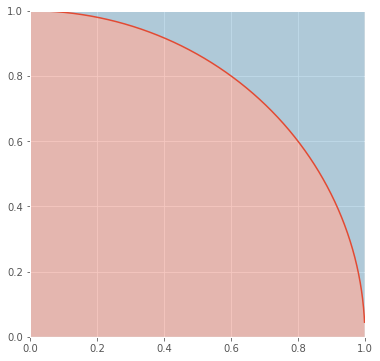

Monte Carlo: nan
Analytical Solution: 0.7853981633974483


In [11]:
NMC = 100
xmc = np.random.rand(NMC)
ymc = np.random.rand(NMC)
@interact(mcs=(0, NMC, 1))
def animation(mcs=0):
    plt.figure(figsize=(6, 6))
    plt.xlim([0,1])
    plt.ylim([0,1])
    x = np.arange(0, 1, 0.001)
    y = (1 - x ** 2)** 0.5
    y2 = np.ones(x.shape[0])
    plt.plot(x, y)
    plt.fill_between(x, y, alpha=0.3)
    plt.fill_between(x, y, y2, alpha=0.3)
    r = (xmc[:mcs] ** 2 + ymc[:mcs] ** 2) ** 0.5
    accept = np.where(r<=1, 1, 0)
    accept_ratio = np.sum(accept) / mcs
    plt.scatter(xmc[:mcs], ymc[:mcs], color="black", marker=".")
    plt.show()
    print('Monte Carlo:', accept_ratio)
    print('Analytical Solution:', np.pi/4.0)

# M-Hアルゴリズム

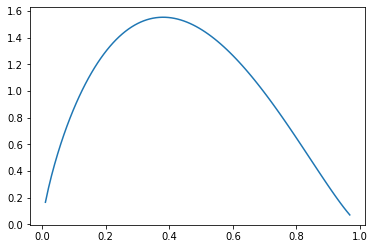

In [35]:
a, b = 1.8, 2.3
x = np.linspace(beta.ppf(0.001, a, b), beta.ppf(0.999, a, b), 100)
plt.plot(x, beta.pdf(x, a, b))

In [38]:
theta = 0.8
NMCS = 20000
epsilon = 0.5
theta_mcs = [theta]
for i in range(NMCS):
    theta_new = theta + epsilon * np.random.randn()
    if beta.pdf(theta_new, a, b) > beta.pdf(theta, a, b):
        theta = theta_new
    else:
        r = beta.pdf(theta_new, a, b) / beta.pdf(theta, a, b)
        if np.random.rand() < r:
            theta = theta_new
    theta_mcs.append(theta)
df = pd.DataFrame(theta_mcs)

In [33]:
df.head()

,0
0,0.800000
1,0.827883
2,0.827883
3,0.406245
4,0.647082


Text(0, 0.5, '$\\Theta$')

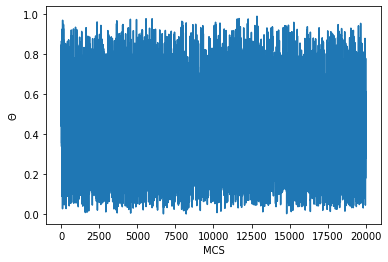

In [39]:
plt.plot(df[0])
plt.xlabel('MCS')
plt.ylabel('$\Theta$')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


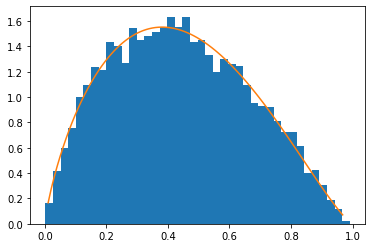

In [41]:
plt.hist(df[0][1000:], normed=True, bins=40)
x = np.linspace(beta.ppf(0.001, a, b), beta.ppf(0.999, a, b), 100)
plt.plot(x, beta.pdf(x, a, b))

# 棄却サンプリング

In [8]:
f = beta(a=a, b=b).pdf
res = opt.fmin(lambda x: -f(x), 0.3)
y_max = f(res)

Optimization terminated successfully.
         Current function value: -1.552959
         Iterations: 12
         Function evaluations: 24


In [9]:
y_max

array([1.5529586])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


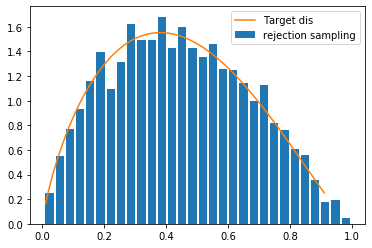

In [10]:
NMCS = 5000
x_mcs = uniform.rvs(size=NMCS)
r = uniform.rvs(size=NMCS) * y_max
accept = x_mcs[r <= f(x_mcs)]
plt.hist(accept, normed=True, bins=30, rwidth=0.8, label='rejection sampling')
x = np.linspace(beta.ppf(0.001, a, b), beta.ppf(0.99, a, b), 100)
plt.plot(x, beta.pdf(x, a, b), label='Target dis')
plt.legend()

# 次元の呪い

In [19]:
accept_dict = {}
NMCS = 40000
Ndim = 15
accept = 0
for i in range(NMCS):
    x = 2 * np.random.rand(Ndim) - 1.0
    r = (np.sum(x**2)) ** 0.5
    if r <= 1:
        accept += 1
accept_ratio = accept / NMCS
analytical = np.pi ** (Ndim/2.0) / (2 ** Ndim * gamma(Ndim/2 + 1))
print('accept ratio:', accept_ratio)
print('analytical solution:', analytical)
accept_dict.update({Ndim:accept_ratio/analytical})

accept ratio: 0.0
analytical solution: 1.1640725122781505e-05


In [20]:
df = pd.DataFrame.from_dict(accept_dict, orient='index')

Text(0, 0.5, 'ratio[-]')

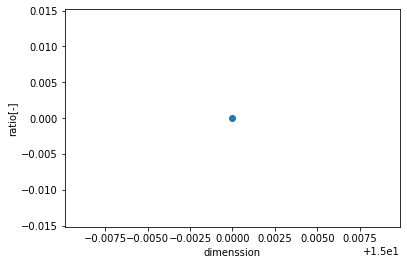

In [25]:
plt.scatter(df.index,df[0])
plt.xlabel('dimenssion')
plt.ylabel('ratio[-]')

# MCMCと定常分析

In [6]:
p_trans = np.zeros([3, 3])

In [7]:
p_trans[0,0] = 0.1
p_trans[0,1] = 0.2
p_trans[0,2] = 0.7
p_trans[1,0] = 0.1
p_trans[1,1] = 0.4
p_trans[1,2] = 0.5
p_trans[2,0] = 0.3
p_trans[2,1] = 0.3
p_trans[2,2] = 0.4

In [8]:
p_trans

array([[0.1, 0.2, 0.7],
       [0.1, 0.4, 0.5],
       [0.3, 0.3, 0.4]])

In [10]:
NMCS = 400
c_state = 0
c_arr =[c_state]
for i in range(NMCS):
    current = np.random.choice(3, 1, p=p_trans[c_state, :])
    c_state = current[0]
    c_arr.append(c_state)
df = pd.DataFrame(c_arr)

In [11]:
df.head()

,0
0,0
1,1
2,1
3,2
4,2


Text(0, 0.5, 'place')

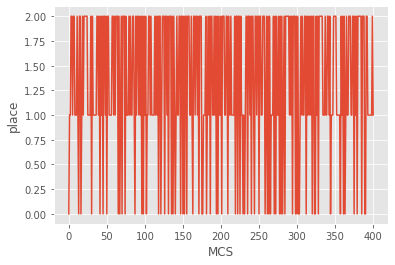

In [12]:
plt.plot(df[0])
plt.xlabel('MCS')
plt.ylabel('place')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


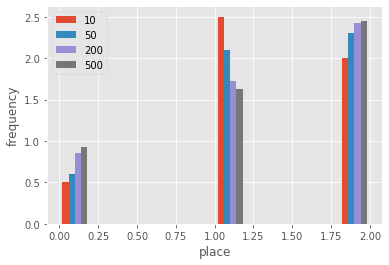

In [15]:
plt.hist([df[0][:10], df[0][:50], df[0][:200], df[0][:400]], normed=True, label=['10','50','200','500'])
plt.xlabel('place')
plt.ylabel('frequency')
plt.legend()

# Gibbsサンプラー

In [57]:
mu = np.array([1, 2])
cov = np.array([[1.0,0.7],[0.7,1.0]])

In [58]:
x = np.arange(-2, 4, 0.01)
y = np.arange(-1, 5, 0.01)
X, Y = np.meshgrid(x, y)
pos = np.zeros([X.shape[0], X.shape[1],2])
pos[:,:,0] = X
pos[:,:,1] = Y

Text(0, 0.5, '$x_{2}$')

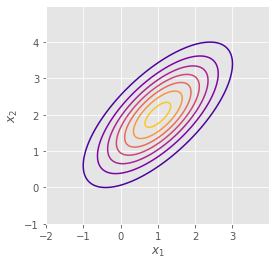

In [59]:
rv = multivariate_normal(mu, cov)
plt.figure(figsize=(4,4))
plt.contour(X, Y, rv.pdf(pos), cmap='plasma')
plt.xlabel('$x_{1}$')
plt.ylabel('$x_{2}$')

In [60]:
NMCS = 500
sigma12 = cov[1, 0]
sigma1 = cov[0,0] ** 0.5
sigma2 = cov[1,1] ** 0.5
rho = sigma12 / (sigma1*sigma2)
z1 = 0.0
z2 = 0.0
z1_mcs = [z1]
z2_mcs = [z2]
for i in range(NMCS):
    #f(z1/z2)
    z1 = norm.rvs(loc=rho*z2, scale=(1-rho**2)**0.5)
    z1_mcs.append(z1)
    z2_mcs.append(z2)
df1 = pd.DataFrame(mu[0] + np.array(z1_mcs) * sigma1)
df2 = pd.DataFrame(mu[1] + np.array(z2_mcs) * sigma2)

In [61]:
df1.head()

,0
0,1.000000
1,0.224705
2,1.712247
3,1.202087
4,-0.075710


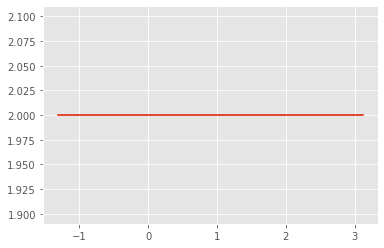

In [62]:
plt.plot(df1[0],df2[0])

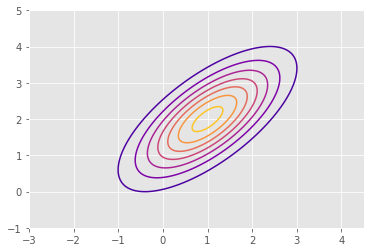

In [64]:
@interact(mcs=(0, 100, 1))
def animation(mcs=0):
    plt.contour(X, Y, rv.pdf(pos), cmap='plasma')
    plt.xlim([-3.0, 4.5])
    plt.ylim([-1.0, 5.0])
    plt.plot(df1[0][:mcs], df2[0][:mcs])
    plt.show()